### Predicting Fifa Players Salary
### STAT 411 FALL 19
### Luke, Lee, Jordana, Sam


1. 
    * Our dataset is taken from the FIFA video game from 2018 and tells us every player (17,981 payers) that played in the FIFA 2018 league and over 70 attributes.. This data includes their positioning information as well as their skills based on their performance in the game. The overall feature gives us their overall performance score based on all the individual attributes while potential tells us what their score should be. The dataset also includes wage and value which tells us their yearly salary and their net worth. We had to fix the symbols for the prices since the original dataset was in euros and included “M” for millions and “K” for thousands. The players’ club and age is also represented within this dataset.

2. 
    * We are asking which attributes have the most significance when it comes to a players salary and relating specific attributes to an individual players salary. 
    * This nonlinear regression problem is important for the national club team managers and coaches to understand if their players are worth the amount that they are spending on each player based on their overall performance and attributes. They may need to know this if they have a salary cap for their team or individual players. 

3. No ethical considerations


In [43]:
import numpy as np                   
import pandas as pa                 
import matplotlib.pyplot as plt      
import seaborn as sn                
import numpy.random as rn
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
import matplotlib.colors as pltco 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

### Import Data Frame assign the name fifa
* Print out the head() or first 5 rows
* Importing data from drop box online

In [44]:
fifa = pa.read_csv('https://www.dropbox.com/s/ov362sryogd0942/CompleteDataset.csv?dl=1', low_memory=False)

fifa.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Acceleration,Aggression,...,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,Position
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,89,63,...,83,94,23,91,92,31,80,85,88,ST LW
1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,92,48,...,88,85,26,87,73,28,59,90,85,RW
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,94,56,...,81,80,33,90,78,24,53,80,83,LW
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,88,78,...,83,87,38,77,89,45,80,84,88,ST
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,€61M,€230K,58,29,...,55,25,11,61,44,10,83,70,11,GK


In [45]:
def shuffle_split(mlp2):
    ss = ShuffleSplit(n_splits=5, test_size=0.1).split(X)
    score_train = []
    score_test = []
    for train_index, test_index in ss:
        mlp2.fit(X[train_index,:],y[train_index])
        score_train+=[mlp2.score(X[train_index,:],y[train_index])]
        score_test+=[mlp2.score(X[test_index,:],y[test_index])]
    return score_test

### Fixing Bad Data
* Stripped "€" from the front of Wage and "K" from the end
    * We did this so we could convert the wage into a float dtype
* Our attributes values contained a "+" or "-"
    * We removed them in front or behind our int values
    * We removed them if they were in between two int values
        * We stripped the values after the symbol so (79+2 = 79)
    * We did this so we can convert the dtype from string to float 

In [46]:
fifa['Wage'] = fifa['Wage'].map(lambda x: x.lstrip('€').rstrip('K'))

* removeStrings - searches each instance in our data frame and removes it and everything to its right
    1. It looks at each instance in our data frame
        1. searches for "+" then removes it if its finds it and returns the values to its left
        2. searches for "-" then removes it if its finds it and returns the values to its left
        3. returns the instance in the data frame with all the symbols removed

In [47]:
A = fifa["Age"] = fifa.Age.astype(float)
B = fifa["Overall"] = fifa.Overall.astype(float)
C = fifa["Wage"] = fifa.Wage.astype(float)
D = fifa["Potential"] = fifa.Potential.astype(float)

In [48]:
def removeStrings (X):
    if '+' in X:
        K = X.find('+')
        return X[:K]
    if '-' in X:
        K = X.find('-')
        return X[:K]
    else:  
        return X

* convertFloat - accepts the data frame with symbols removed and converts the dtype 
    1. It looks at one specific feature and then each instance in that feature
    2. Because we already removed the symbol with removeString this converts the dtype to float

In [49]:
def convertFloat(fifa, feature):
    for K in fifa.index: 
        fifa.loc[K,feature] = removeStrings(fifa.loc[K, feature])

    
    fifa.loc[:, feature] = fifa.loc[:,feature].astype("float")  
    return fifa

### Converting Columns to dtype float so we can use them 
    * Acceleration, Aggression, Agility, Balance, Ball Control, Sprint Speed, Composure, and Dribbling

In [50]:
fifa = convertFloat(fifa, "Acceleration")
fifa = convertFloat(fifa, "Aggression")
fifa = convertFloat(fifa, "Agility")
fifa = convertFloat(fifa, "Balance")
fifa = convertFloat(fifa, "Ball control")
fifa = convertFloat(fifa, 'Sprint speed')
fifa = convertFloat(fifa, 'Composure')
fifa = convertFloat(fifa, 'Dribbling')
fifa = convertFloat(fifa, 'Sliding tackle') 

### Bad Models
* Our data set is non linear and so any linear model is not a good predictor of wage and should typically be a bad fit
* PCA models usually represent a classification problem and we have a regression problem

In [51]:
def plot_reg_model(reg, X, y):

    n = X.shape[0]
    test = int(0.20*n)            
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]       
    y_test = y[:test]
    X_train = X[test:]     
    y_train = y[test:]
    
    reg.fit(X_train, y_train) 
     
    nn = 200
    
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nn),   
        np.linspace(y_min, y_max, nn))                    
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()]) 

  
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, marker='o')
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))
    
    return reg

### Linear Model for Agility and Overall VS Wage
* We expect it to be a bad model because our data isnt linear
* We see that we have much better chance at predicting our wage using non linear models

In [52]:
X = np.array(fifa[['Agility', 'Overall']])
y = np.array(fifa['Wage'])

Training R2: 0.3493151042779411
Testing R2: 0.3679912283009882


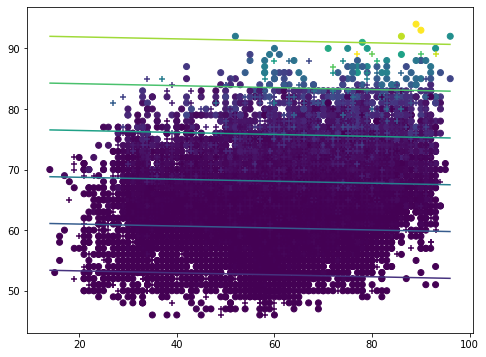

In [53]:
reg2 = LinearRegression()
plot_reg_model(reg2, X, y)
shuffle_split(reg2)
plt.show()

### PCA Model 
* We expect this model to be a poor fit for us because it is a classification model and we are asking a regression problem
* In this model we get a super small training and testing data which doesnt help us predict the wage at all
* We might have some outliers that are skewing our data

In [54]:
X = np.array(fifa.iloc[:,7:10])
y = np.array(fifa.iloc[:, 1])

pca = PCA(n_components=2)
Xpca = pca.fit_transform(X);

import numpy.random as rn
n = X.shape[0]
test = int(0.25*n)          
perm = rn.permutation(n)   
X = Xpca[perm]
y = y[perm]
X_test = Xpca[:test]     
y_test = y[:test]
X_train = Xpca[test:]   
y_train = y[test:]

In [55]:
cat1 = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train[:, 0:2], y_train)
cat1.score(X_train[:, 0:2], y_train), cat1.score(X_test[:, 0:2], y_test)

(0.08675663651193831, 0.07363737486095662)

In [56]:
def plot_reg_model(reg, X_train, y_train, X_test, y_test):

    h = 0.01 
    
    x_min, x_max = -40.0, 40.0
    y_min, y_max = -20.0, 20.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))

Training R2: 0.0005233627759448911
Testing R2: -0.04497176428684524


[0.0352251937129372,
 0.05858111791853015,
 0.036715983213630454,
 0.04440130775763418,
 0.036670777371393126]

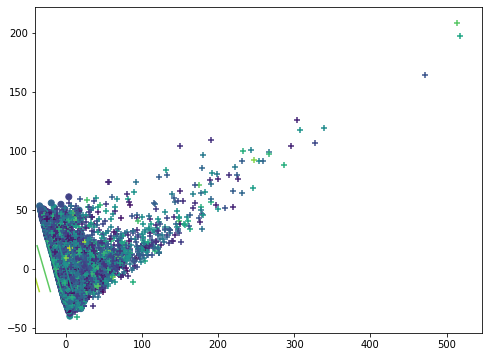

In [57]:
reg = LinearRegression()
reg.fit(X_train,y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)
shuffle_split(reg)

### Ridge and Lasso 
* We picked Overall + some features VS Wage
    1. We picked Agility 
    2. We picked Ball Control
* The strategy in picking this model was to run some of our features through it to see if there is a pattern in certain features. This would help give us a baseline of features to run in the next models.
* This was effective in helping us understand the correlation between our features and the wage. Though the numbers might not look to good, it did start to give us a good idea on certain features. 

### Agility + Overall

In [58]:
def plot_reg_model(reg, X, y):


    n = X.shape[0]
    test = int(0.30*n)           
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]      
    y_test = y[:test]
    X_train = X[test:]     
    y_train = y[test:]
    
    reg.fit(X_train, y_train) 
     
    nn = 200
    
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nn),   
        np.linspace(y_min, y_max, nn))                    
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()]) 

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))
    
    return reg

In [59]:
X = np.array(fifa[['Agility', 'Overall']])
y = np.array(fifa['Wage'])

Training R2: 0.34425760044449905
Testing R2: 0.37917268346028266
Ridge Mean R2: -89.69900138200245
Ridge Standard Deviation R2: 257.0592637304389


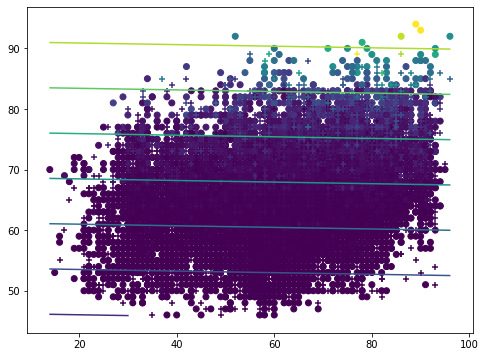

In [60]:
ridge2 = Ridge(alpha=1)  # alpha = 1 for both ridge and lasso made lasso a better fit
plot_reg_model(ridge2, X, y);

ridge = cross_val_score(ridge2, X, y, cv=10)
print('Ridge Mean R2: {}'.format(ridge.mean()))
print('Ridge Standard Deviation R2: {}'.format(ridge.std()))

Training R2: 0.34837178707887506
Testing R2: 0.3662403092584833
Lasso Mean R2: -86.86846732479378
Lasso Standard Deviation R2: 248.97339510556557


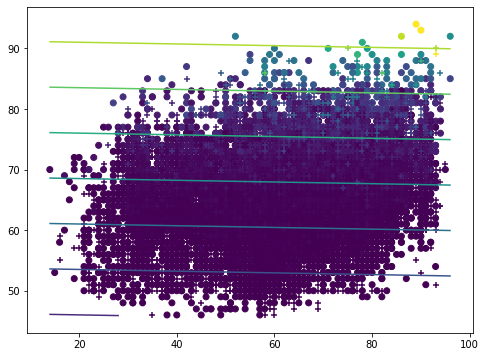

In [62]:
lasso2=Lasso(alpha=1)
plot_reg_model(lasso2, X, y);

lasso = cross_val_score(lasso2, X, y, cv=10)
print('Lasso Mean R2: {}'.format(lasso.mean()))
print('Lasso Standard Deviation R2: {}'.format(lasso.std()))

### Ball Control + Overall

In [63]:
X = np.array(fifa[['Ball control', 'Overall']])
y = np.array(fifa['Wage'])

Training R2: 0.3532552672775112
Testing R2: 0.3536767310753816
Ridge Mean R2: -90.19051813848652
Ridge Standard Deviation R2: 258.53798852662555


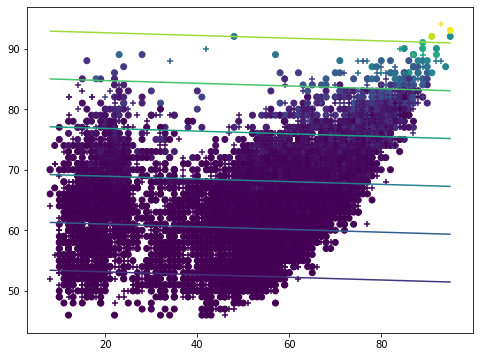

In [65]:
ridge_reg = Ridge(alpha=2)
plot_reg_model(ridge_reg, X, y);

ridge = cross_val_score(ridge_reg, X, y, cv=10)
print('Ridge Mean R2: {}'.format(ridge.mean()))
print('Ridge Standard Deviation R2: {}'.format(ridge.std()))

Training R2: 0.3457155132926566
Testing R2: 0.3733987379252903
Lasso Mean R2: -87.40693529962627
Lasso Standard Deviation R2: 250.57501710189933


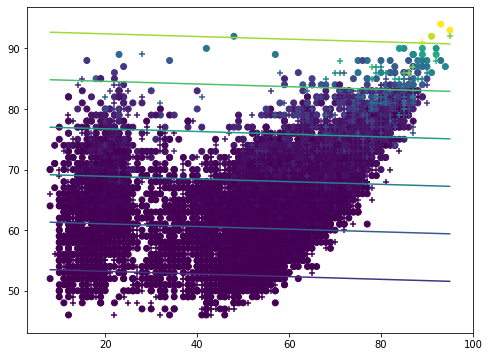

In [66]:
lasso_reg=Lasso(alpha=1)
plot_reg_model(lasso_reg, X, y);

lasso = cross_val_score(lasso_reg, X, y, cv=10)
print('Lasso Mean R2: {}'.format(lasso.mean()))
print('Lasso Standard Deviation R2: {}'.format(lasso.std()))

### K- nearest neighbors
* We picked Overall + some feature VS Wage
    1. We picked Sprint Speed for over all fitness/attack
    2. We picked Dribbling for ball control abilities/midfield
    3. We picked Sliding Tackle for defense
* Strategy for picking best models 
* This was an effective model for our data set because the model best fits regression problems and our training and testing data R2 are the closest for this model. We predicted that offensive skills would have more significance on the wage and because of this model it confirms our hypothesis.


In [67]:
def plot_reg_model(reg, X_train, y_train, X_test, y_test):

    h = 0.01 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = -0.1, 1.1
    y_min, y_max = -0.1, 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5, 5))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))

In [68]:
X = np.array(fifa[['Overall', 'Sprint speed']])
y = np.array(fifa.iloc[:, 7])

for l in range(X.shape[1]):
    X[:, l] = ( X[:, l] - min(X[:, l]))/(max(X[:, l]) - min(X[:, l]))
    
n = X.shape[0]
test = int(0.30*n)          
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]      
y_test = y[:test]
X_train = X[test:]   
y_train = y[test:]

### Overall and Sprint Speed vs Wage

Training R2: 0.3582918947650021
Testing R2: 0.3424076144139727
KNN Mean R2: 0.4695078224898184
KNN Standard Deviation R2: 0.09998940089486465


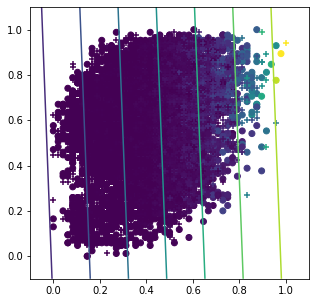

In [69]:
reg1 = KNeighborsRegressor(n_neighbors=1)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)

knn = cross_val_score(reg1, X, y, cv=10)
print('KNN Mean R2: {}'.format(knn.mean()))
print('KNN Standard Deviation R2: {}'.format(knn.std()))

Training R2: 0.3582918947650021
Testing R2: 0.3424076144139727
KNN Mean R2: 0.7120820514246952
KNN Standard Deviation R2: 0.03168676339033319


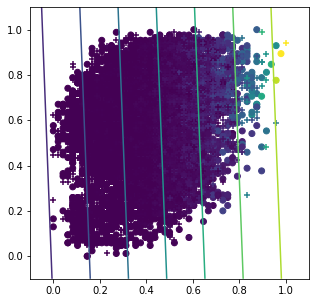

In [70]:
reg2 = KNeighborsRegressor(n_neighbors=10)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)

knn1 = cross_val_score(reg2, X, y, cv=10)
print('KNN Mean R2: {}'.format(knn1.mean()))
print('KNN Standard Deviation R2: {}'.format(knn1.std()))

### Overall and Dribbling vs Wage

In [71]:
X = np.array(fifa[['Overall', 'Dribbling']])
y = np.array(fifa.iloc[:, 7])

for l in range(X.shape[1]):
    X[:, l] = ( X[:, l] - min(X[:, l]))/(max(X[:, l]) - min(X[:, l]))
    
n = X.shape[0]
test = int(0.30*n)          
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]      
y_test = y[:test]
X_train = X[test:]   
y_train = y[test:]

Training R2: 0.36114512678386623
Testing R2: 0.3407687800483479
KNN Mean R2: 0.7238654977254697
KNN Standard Deviation R2: 0.03628163185852497


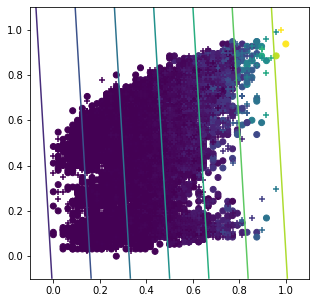

In [72]:
reg3 = KNeighborsRegressor(n_neighbors=1)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)

knn2 = cross_val_score(reg2, X, y, cv=10)
print('KNN Mean R2: {}'.format(knn2.mean()))
print('KNN Standard Deviation R2: {}'.format(knn2.std()))

Training R2: 0.36114512678386623
Testing R2: 0.3407687800483479
KNN Mean R2: 0.7238654977254697
KNN Standard Deviation R2: 0.03628163185852497


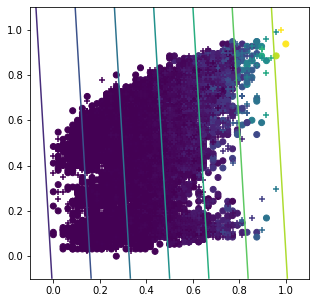

In [73]:
reg4 = KNeighborsRegressor(n_neighbors=10)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)

knn3 = cross_val_score(reg4, X, y, cv=10)
print('KNN Mean R2: {}'.format(knn3.mean()))
print('KNN Standard Deviation R2: {}'.format(knn3.std()))

### Overall and Sliding Tackle vs Wage

In [74]:
X = np.array(fifa[['Overall', 'Sliding tackle']])
y = np.array(fifa.iloc[:, 7])

for l in range(X.shape[1]):
    X[:, l] = ( X[:, l] - min(X[:, l]))/(max(X[:, l]) - min(X[:, l]))
    
n = X.shape[0]
test = int(0.30*n)          
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]      
y_test = y[:test]
X_train = X[test:]   
y_train = y[test:]

Training R2: 0.3522353549532492
Testing R2: 0.3535224069075783
KNN Mean R2: 0.5090129574302179
KNN Standard Deviation R2: 0.07504761401200757


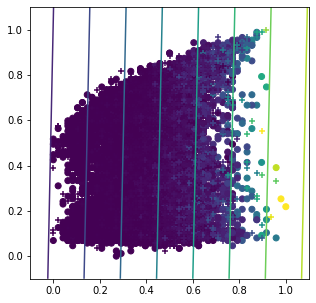

In [75]:
reg5 = KNeighborsRegressor(n_neighbors=1)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)

knn4 = cross_val_score(reg5, X, y, cv=10)
print('KNN Mean R2: {}'.format(knn4.mean()))
print('KNN Standard Deviation R2: {}'.format(knn4.std()))

Training R2: 0.3522353549532492
Testing R2: 0.3535224069075783
KNN Mean R2: 0.70258705809529
KNN Standard Deviation R2: 0.02869781775938835


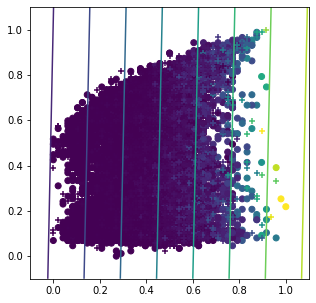

In [76]:
reg6 = KNeighborsRegressor(n_neighbors=10)
reg.fit(X_train, y_train)
plot_reg_model(reg, X_train, y_train, X_test, y_test)

knn5 = cross_val_score(reg6, X, y, cv=10)
print('KNN Mean R2: {}'.format(knn5.mean()))
print('KNN Standard Deviation R2: {}'.format(knn5.std()))

### Nueral Network Models
* We used our other models that we have already shown to find what attributes have the largest significance on wage
    1. We chose our "offensive" skills becasuse we found those are better predictors of wage than defensive/goalkeeping abilities
* Strategy for evaluating the models
    1. We notice we get better result for ball control in nueral networks which contradict what we have for ridge and lasso above
* The models with offensive skills tend to work better to predict our hypothesis and we know this because our models with those skills test and train better

### Agility and Overall VS Wage 

In [77]:
X = np.array(fifa[['Agility', 'Overall']])
y = np.array(fifa['Wage'])

In [78]:
def plot_reg_model(reg, X, y):


    n = X.shape[0]
    test = int(0.20*n)          
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]     
    y_test = y[:test]
    X_train = X[test:]   
    y_train = y[test:]
    
    reg.fit(X_train, y_train) 
     
    nn = 200
   
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nn),   
        np.linspace(y_min, y_max, nn))                    
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()]) 
   
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))
    
    return reg

Training R2: 0.3506805696001782
Testing R2: 0.35956596634701976


[0.39763163484822545,
 0.36527288339090647,
 0.32697080919429755,
 0.38284838949406463,
 0.4245675278479215]

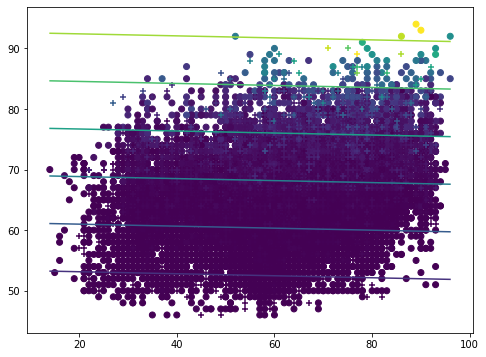

In [79]:
r_reg = Ridge(alpha=2)
plot_reg_model(r_reg, X, y);
shuffle_split(r_reg)

Training R2: 0.34864613552850476
Testing R2: 0.3765105007443377


[0.3528417092734155,
 0.3656683467053563,
 0.3218863179870548,
 0.3781634825144647,
 0.35057597163040466]

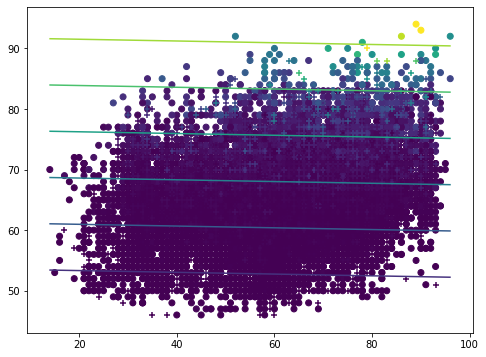

In [80]:
l_reg=Lasso(alpha=1)
plot_reg_model(l_reg, X, y);
shuffle_split(l_reg)

Training R2: 0.7889893105999938
Testing R2: 0.7098765923195927


[0.6876277273156914,
 0.7153817479624593,
 0.7175425784841517,
 0.6993673809484111,
 0.6999499834714145]

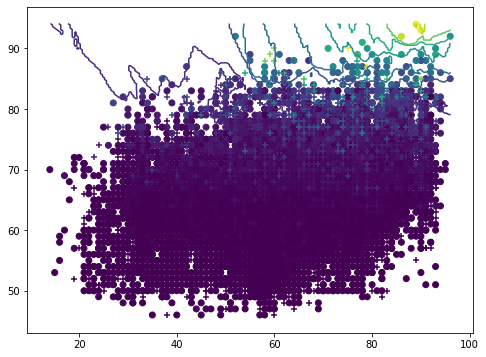

In [81]:
knn = KNeighborsRegressor(n_neighbors=6)
plot_reg_model(knn, X, y);
shuffle_split(knn)

Training R2: 0.8279327814898527
Testing R2: 0.6815626570597442


[0.7117949613070418,
 0.6157211431263542,
 0.7006704744748804,
 0.7235811201858221,
 0.6305291634800317]

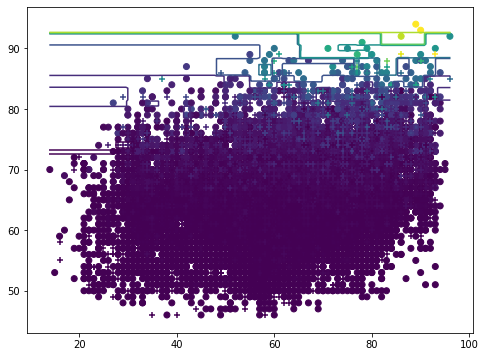

In [82]:
tree = DecisionTreeRegressor(max_depth=10)
plot_reg_model(tree, X, y);
shuffle_split(tree)

### Sprint Speed and Overall Vs Wage

In [83]:
X = np.array(fifa[['Sprint speed', 'Overall']])
y = np.array(fifa['Wage'])

Training R2: 0.3494643628614825
Testing R2: 0.36949634906372814


[0.3776350235786682,
 0.35716858535635854,
 0.3792271844513423,
 0.3199171353555962,
 0.34053176078572545]

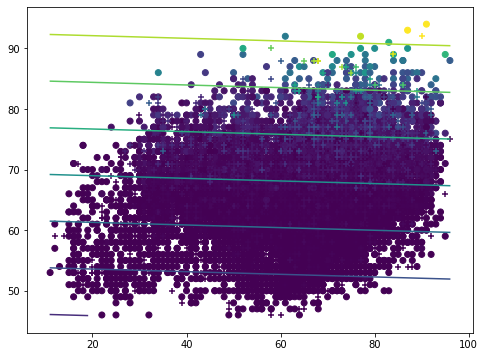

In [84]:
r_reg = Ridge(alpha=2)
plot_reg_model(r_reg, X, y);
shuffle_split(r_reg)

Training R2: 0.3604608059852308
Testing R2: 0.3248025007116393


[0.3690425249057216,
 0.3656377459738935,
 0.3241457118600425,
 0.364270923058564,
 0.34202455406500953]

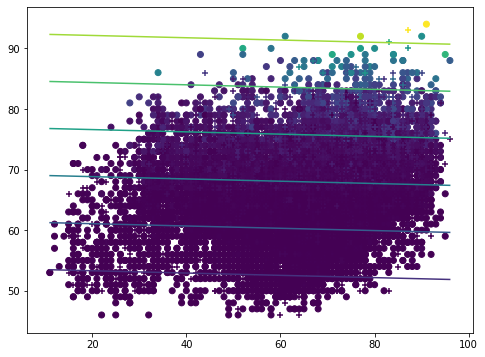

In [85]:
l_reg=Lasso(alpha=1)
plot_reg_model(l_reg, X, y);
shuffle_split(l_reg)

Training R2: 0.7755947029917867
Testing R2: 0.7005672745313953


[0.6451753919956902,
 0.6181697684663991,
 0.6787758806929608,
 0.7190387013686614,
 0.7361417511646464]

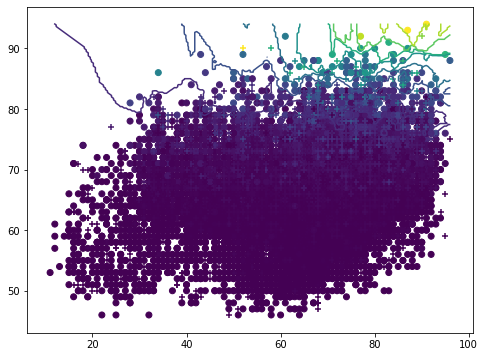

In [86]:
knn = KNeighborsRegressor(n_neighbors=6)
plot_reg_model(knn, X, y);
shuffle_split(knn)

Training R2: 0.8147349404548602
Testing R2: 0.7406499113930697


[0.6548522116116753,
 0.6895060375030373,
 0.7226824254460602,
 0.6721960294632573,
 0.697776301803842]

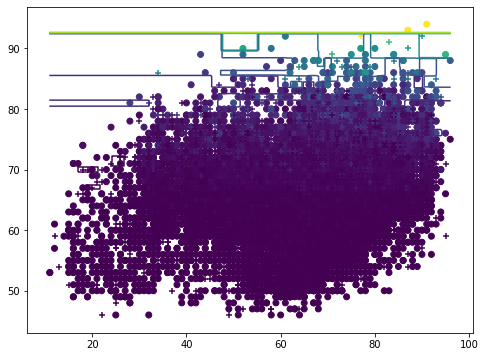

In [87]:
tree = DecisionTreeRegressor(max_depth=10)
plot_reg_model(tree, X, y);
shuffle_split(tree)

### Ball Control and Overall Vs Wage
* These attributes fit best for Nueral Networks which contradicts some other models

In [88]:
X = np.array(fifa[['Ball control', 'Overall']])
y = np.array(fifa['Wage'])

Training R2: 0.35598154499264406
Testing R2: 0.34424174173288513


[0.4081625022579717,
 0.32302283038498536,
 0.39848190597863337,
 0.36864806428384944,
 0.3267854872735202]

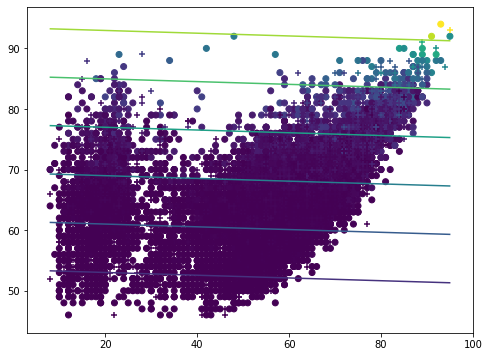

In [89]:
r_reg = Ridge(alpha=2)
plot_reg_model(r_reg, X, y);
shuffle_split(r_reg)

Training R2: 0.36097353194977566
Testing R2: 0.3265896516215724


[0.3810282294212791,
 0.39337317341927847,
 0.3797255791081207,
 0.38869622163792933,
 0.39147461393742733]

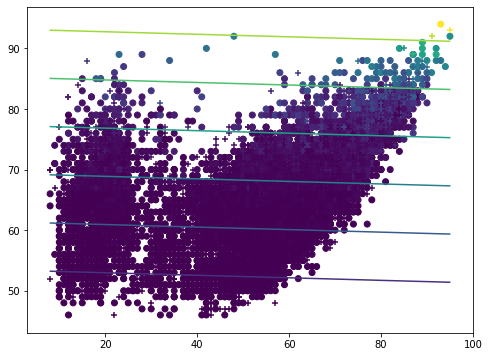

In [90]:
l_reg=Lasso(alpha=1)
plot_reg_model(l_reg, X, y);
shuffle_split(l_reg)

Training R2: 0.7723262192209626
Testing R2: 0.725111830810905


[0.757372297345881,
 0.7717532160645451,
 0.7371495219629314,
 0.7025350877699376,
 0.7458620901439155]

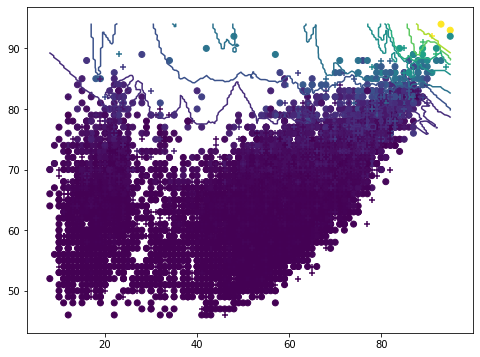

In [91]:
knn = KNeighborsRegressor(n_neighbors=6)
plot_reg_model(knn, X, y);
shuffle_split(knn)

Training R2: 0.8295564582608947
Testing R2: 0.6521371007938501


[0.8043269439811088,
 0.7310133545120538,
 0.7002348848283866,
 0.7297958873779034,
 0.6210266044956807]

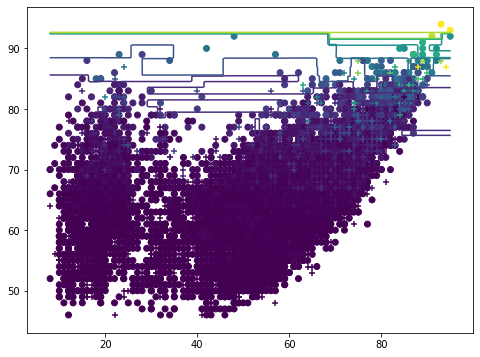

In [92]:
tree = DecisionTreeRegressor(max_depth=10)
plot_reg_model(tree, X, y);
shuffle_split(tree)

### Decision Tree Model
* Using the descision tree model we used overall and age 
*
*

In [93]:
from sklearn.tree import export_graphviz
import graphviz

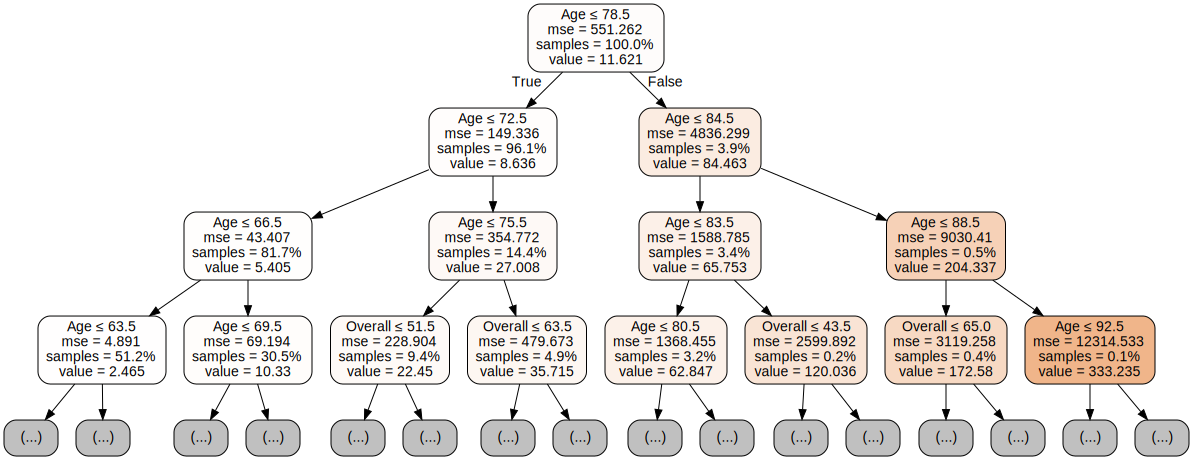

In [94]:
export_graphviz(tree, out_file='tree-1.dot', feature_names=['Overall', 'Age'], rounded=True, filled=True,
                    special_characters=True, max_depth=3, proportion=True, precision=3,  leaves_parallel=False)

with open('tree-1.dot') as f:
    dot_graph = f.read()



display( graphviz.Source(dot_graph) )

Training R2: 0.8123310756345098
Testing R2: 0.7500696953052414


[0.7120798995159907,
 0.6882755265352816,
 0.7135547494957213,
 0.6453004064039393,
 0.7657490018190163]

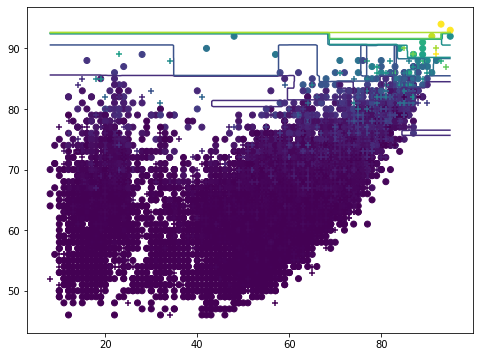

In [95]:
tree1= DecisionTreeRegressor(max_depth=10)
plot_reg_model(tree, X, y);
shuffle_split(tree1)

## Ensemble Models
* We used the "defensive" feature to evaluate the forest and boosting methods
* Strategy for evaluating the models
    1. Both models gave a pretty good prediction based on given features

### Agility and Overall vs Wage

In [96]:
X = np.array(fifa[['Agility', 'Overall']])
y = np.array(fifa['Wage'])

In [97]:
def plot_reg_model(reg, X, y):


    n = X.shape[0]
    test = int(0.20*n)          
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]     
    y_test = y[:test]
    X_train = X[test:]   
    y_train = y[test:]
    
    reg.fit(X_train, y_train) 
     
    nn = 200
   
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nn),   
        np.linspace(y_min, y_max, nn))                    
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()]) 
   
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))
    
    return reg

Training R2: 0.7413249428891051
Testing R2: 0.7496988528326269


[0.742703432643912,
 0.7342346661259628,
 0.7069507761399643,
 0.7911381058830702,
 0.7400083740335353]

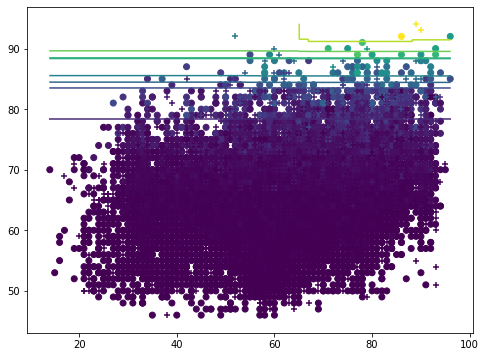

In [98]:
forest = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
plot_reg_model(forest, X, y);
shuffle_split(forest)

Training R2: 0.8039866496325304
Testing R2: 0.7862907717314973


[0.689234198625367,
 0.8163591418584188,
 0.7435779293773287,
 0.698676948303533,
 0.7455512058237306]

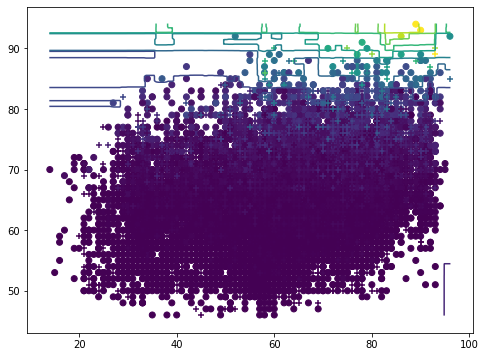

In [99]:
boost = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5)
plot_reg_model(boost, X, y);
shuffle_split(boost)

### Sprint speed and Overall vs Wage

In [100]:
X = np.array(fifa[['Sprint speed', 'Overall']])
y = np.array(fifa['Wage'])

Training R2: 0.7718012207888642
Testing R2: 0.6582259859129006


[0.7113032995298165,
 0.7466528166366797,
 0.7089427630847503,
 0.761551262763076,
 0.7063401633751101]

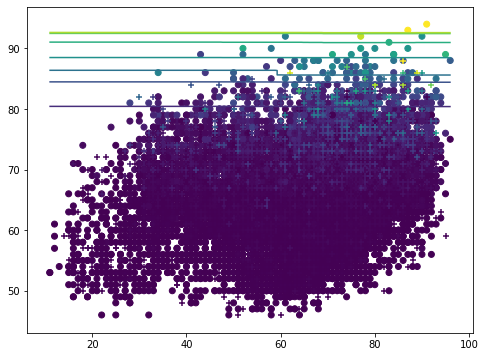

In [101]:
forest = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
plot_reg_model(forest, X, y);
shuffle_split(forest)

Training R2: 0.8069462575696698
Testing R2: 0.7549898233789035


[0.7804746883259037,
 0.8299237928839833,
 0.7002595537924206,
 0.8119709904689598,
 0.7235068455466844]

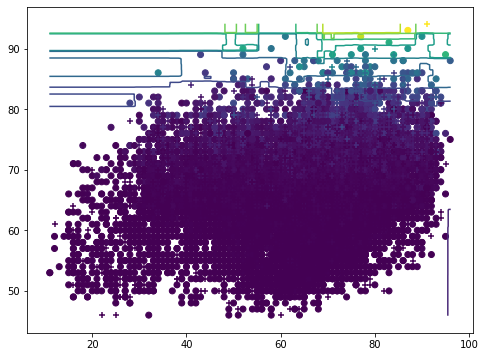

In [102]:
boost = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5)
plot_reg_model(boost, X, y);
shuffle_split(boost)

### Ball control and Overall vs Wage

In [103]:
X = np.array(fifa[['Ball control', 'Overall']])
y = np.array(fifa['Wage'])

Training R2: 0.7661079057522965
Testing R2: 0.6931636211988694


[0.7590432508058907,
 0.7687081041646713,
 0.755945407279105,
 0.7742369296516397,
 0.7221440463650315]

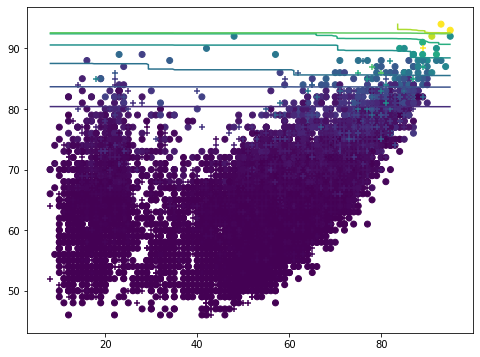

In [104]:
forest = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
plot_reg_model(forest, X, y);
shuffle_split(forest)

Training R2: 0.7970021844216495
Testing R2: 0.7687568672761067


[0.7067820141703305,
 0.8040968633648129,
 0.7565676733965896,
 0.785045785535839,
 0.7571282024915484]

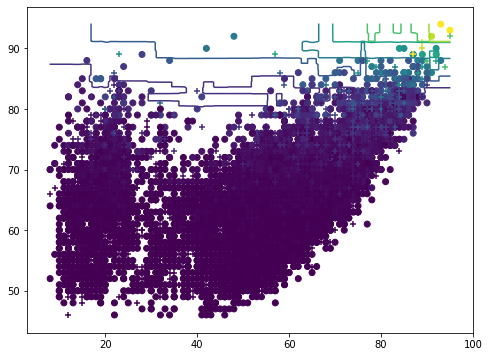

In [105]:
boost = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5)
plot_reg_model(boost, X, y);
shuffle_split(boost)

### Conclusion
* PCA and linear regression did not really give us the best results
* K-nearest neighbors and neural networking had the best results
    * supported by cross validation and shuffle split values
* Since all the features were not relevant to eachother based on position it was best to select attributes that related to offense, defense, and overall


### OVERALL
* #### Offensive players tend to get paid more when considering their offensive skills, while their defensive and goalie skills do not give good predictors for wage. 
* #### Those who are good offensive players, such as forwards and others who score goals, are paid more than the defensive players in the FIFA league. 
